# Autonomous Detection - Car Detection with YOLO

Build a car detection system. To collect data, let's say a camera is mounted to the hood (meaning the front) of the car, which takes pictures of the road ahead every few seconds as the car drives around. Gather all these images into a folder and label them by drawing bounding boxes around every car found on the road.

Here's an example of what the bounding boxes would look like:

<img src="images/box_label.png" style="width:500px;height:250;">
<caption><center><font color="purple"><u><b>Figure 1</b></u>: Definition of a box<br></font></center></caption>

If there are 80 classes we want the object detector to recognize, we can represent the class label $c$ either as an integer from 1 to 80, or as an 80-dimensional vector (with 80 numbers) one component of which is 1, and the rest of which are 0.

## 1 - YOLO

"You Only Look Once" (YOLO) is a popular algorithm because it achieves high accuracy while also being able to run in real time. This algorithm "only looks once" at the image in the sense that it requires only one forward propagation pass through the network to make predictions. After non-max suppression, it then outputs recognized objects together with the bounding boxes.

### 1.1 - Model Details

#### Inputs and outputs
- The **input** is a batch of images, and each image has the shape (608, 608, 3)
- The **output** is a list of bounding boxes along with the recognized classes. Each bounding box is represented by 6 numbers $(p_c, b_x, b_y, b_h, b_w, c)$. If we expand $c$ into an 80-dimensional vector, each bounding box is then represented by 85 numbers.

#### Anchor Boxes
* Anchor boxes are chosen by exploring the training data to choose reasonable height/width ratios that represent the different classes. For this notebook, 5 anchor boxes are chosen (to cover the 80 classes), and stored in the file 'utils/yolo_anchors.txt'

```txt
Reading yolo_anchors.txt ...
0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828
```

* The dimension of the encoding tensor of the second to last dimension based on the anchor boxes is $(m,n_H,n_W,anchors,classes)$.
* The YOLO architecture is: IMAGE (m, 608, 608, 3) $\rightarrow$ DEEP CNN $\rightarrow$ ENCODING (m, 19, 19, 5, 85).  

#### Encoding
Let's look in greater detail at what this encoding represents. 

<img src="images/architecture.png" style="width:700px;height:400;">
<caption><center><font color="purple"><u><b> Figure 2</b></u>: Encoding architecture for YOLO<br></font></center></caption>

If the center/midpoint of an object falls into a grid cell, that grid cell is responsible for detecting that object. Since we're using 5 anchor boxes, each of the 19x19 cells thus encodes information about 5 boxes. Anchor boxes are defined only by their width and height. For simplicity, flatten the last two dimensions of the shape (19, 19, 5, 85) encoding, so the output of the Deep CNN is (19, 19, 425).

<img src="images/flatten.png" style="width:700px;height:400;">
<caption><center><font color="purple"><u><b> Figure 3</b></u>: Flattening the last two last dimensions<br></font></center></caption>

#### Class score

Now, for each box (of each cell), compute the following element-wise product and extract a probability that the box contains a certain class. The class score is $score_{c,i} = p_{c} \times c_{i}$: the probability that there is an object $p_{c}$ times the probability that the object is a certain class $c_{i}$.

<img src="images/probability_extraction.png" style="width:700px;height:400;">
<caption><center><font color="purple"><u><b>Figure 4</b></u>: Find the class detected by each box<br></font></center></caption>

##### Example of figure 4
* In figure 4, let's say for box 1 (cell 1), the probability that an object exists is $p_{1}=0.60$.  So there's a 60% chance that an object exists in box 1 (cell 1).  
* The probability that the object is the class "category 3 (a car)" is $c_{3}=0.73$.  
* The score for box 1 and for category "3" is $score_{1,3}=0.60 \times 0.73 = 0.44$.  
* Let's say we calculate the score for all 80 classes in box 1, and find that the score for the car class (class 3) is the maximum. So we'll assign the score 0.44 and class "3" to this box "1".

#### Visualizing classes
Here's one way to visualize what YOLO is predicting on an image:

- For each of the 19x19 grid cells, find the maximum of the probability scores (taking a max across the 80 classes, one maximum for each of the 5 anchor boxes).
- Color that grid cell according to what object that grid cell considers the most likely.

Doing this results in this picture: 

<img src="images/proba_map.png" style="width:300px;height:300;">
<caption><center><font color="purple"><u><b>Figure 5</b></u>: Each one of the 19x19 grid cells is colored according to which class has the largest predicted probability in that cell.<br></font></center></caption>

Note that this visualization isn't a core part of the YOLO algorithm itself for making predictions; it's just a nice way of visualizing an intermediate result of the algorithm.

#### Visualizing bounding boxes
Another way to visualize YOLO's output is to plot the bounding boxes that it outputs. Doing that results in a visualization like this: 

<img src="images/anchor_map.png" style="width:200px;height:200;">
<caption><center><font color="purple"><u><b>Figure 6</b></u>: Each cell gives us 5 boxes. In total, the model predicts: 19x19x5 = 1805 boxes just by looking once at the image (one forward pass through the network)! Different colors denote different classes. <br></font></center></caption>

#### Non-Max suppression
In the figure above, the only boxes plotted are ones for which the model had assigned a high probability, but this is still too many boxes. We'd like to reduce the algorithm's output to a much smaller number of detected objects.  

To do so, we'll use **non-max suppression**. Specifically, we'll carry out these steps: 
- Get rid of boxes with a low score. Meaning, the box is not very confident about detecting a class, either due to the low probability of any object, or low probability of this particular class.
- Select only one box when several boxes overlap with each other and detect the same object.


## Summary for YOLO

- Input image (608, 608, 3)
- The input image goes through a CNN, resulting in a (19, 19, 5, 85) dimensional output. 
- After flattening the last two dimensions, the output is a volume of shape (19, 19, 425):
    - Each cell in a 19x19 grid over the input image gives 425 numbers. 
    - 425 = 5 x 85 because each cell contains predictions for 5 boxes, corresponding to 5 anchor boxes. 
    - 85 = 5 + 80 where 5 is because $(p_c, b_x, b_y, b_h, b_w)$ has 5 numbers, and 80 is the number of classes we'd like to detect
- You then select only few boxes based on:
    - Score-thresholding: throw away boxes that have detected a class with a score less than the threshold
    - Non-max suppression: Compute the Intersection over Union and avoid selecting overlapping boxes
- This gives YOLO's final output. 

In [1]:
import os
from matplotlib.pyplot import imshow
import numpy as np
from PIL import ImageFont, ImageDraw, Image

import tensorflow as tf
from tensorflow.keras.models import load_model

from yad2k.models.keras_yolo import yolo_head
from yad2k.utils.utils import draw_boxes, get_colors_for_classes, scale_boxes, read_classes, read_anchors, preprocess_image

%matplotlib inline

### Filtering with a Threshold on Class Scores

First apply a filter by thresholding, meaning get rid of any box for which the class "score" is less than a chosen threshold. 

The model gives us a total of 19x19x5x85 numbers, with each box described by 85 numbers. It's convenient to rearrange the (19,19,5,85) (or (19,19,425)) dimensional tensor into the following variables:

- `box_confidence`: tensor of shape $(19, 19, 5, 1)$ containing $p_c$ (confidence probability that there's some object) for each of the 5 boxes predicted in each of the 19x19 cells.
- `boxes`: tensor of shape $(19, 19, 5, 4)$ containing the midpoint and dimensions $(b_x, b_y, b_h, b_w)$ for each of the 5 boxes in each cell.
- `box_class_probs`: tensor of shape $(19, 19, 5, 80)$ containing the "class probabilities" $(c_1, c_2, ... c_{80})$ for each of the 80 classes for each of the 5 boxes per cell.

In [2]:
def yolo_filter_boxes(boxes, box_confidence, box_class_probs, threshold=.6):
    """Filters YOLO boxes by thresholding on object and class confidence.
    
    Arguments:
        boxes -- tensor of shape (19, 19, 5, 4)
        box_confidence -- tensor of shape (19, 19, 5, 1)
        box_class_probs -- tensor of shape (19, 19, 5, 80)
        threshold -- real value, if [ highest class probability score < threshold],
                     then get rid of the corresponding box

    Returns:
        scores -- tensor of shape (None,), containing the class probability score for selected boxes
        boxes -- tensor of shape (None, 4), containing (b_x, b_y, b_h, b_w) coordinates of selected boxes
        classes -- tensor of shape (None,), containing the index of the class detected by the selected boxes

    Note: "None" is here because we don't know the exact number of selected boxes, as it depends on the threshold. 
    For example, the actual output size of scores would be (10,) if there are 10 boxes.
    """

    # Step 1: Compute box scores
    box_scores = box_confidence * box_class_probs

    # Step 2: Find the box_classes using the max box_scores, keep track of the corresponding score
    box_classes = tf.math.argmax(box_scores, axis=-1)
    box_class_scores = tf.math.reduce_max(box_scores, axis=-1)
    
    # Step 3: Create a filtering mask based on "box_class_scores" by using "threshold"
    filtering_mask = box_class_scores >= threshold
    
    # Step 4: Apply the mask to box_class_scores, boxes and box_classes
    scores = tf.boolean_mask(box_class_scores, filtering_mask, axis=None)
    boxes = tf.boolean_mask(boxes, filtering_mask, axis=None)
    classes = tf.boolean_mask(box_classes, filtering_mask, axis=None)
    
    return scores, boxes, classes

### Non-max Suppression

Even after filtering by thresholding over the class scores, we still end up with a lot of overlapping boxes. A second filter for selecting the right boxes is called non-maximum suppression (NMS).

<img src="images/non-max-suppression.png" style="width:500px;height:400;">
<caption><center><font color="purple"><u> <b>Figure 7</b> </u>: In this example, the model has predicted 3 cars, but it's actually 3 predictions of the same car. Running non-max suppression (NMS) will select only the most accurate (highest probability) of the 3 boxes. <br></font> </center></caption>

Non-max suppression uses the very important function called **"Intersection over Union"**, or IoU.
<img src="images/iou.png" style="width:500px;height:400;">
<caption><center><font color="purple"><u> <b>Figure 8</b> </u>: Definition of "Intersection over Union". <br></font></center></caption>

- This code uses the convention that (0,0) is the top-left corner of an image, (1,0) is the upper-right corner, and (1,1) is the lower-right corner. In other words, the (0,0) origin starts at the top left corner of the image. As $x$ increases, move to the right. As $y$ increases, move down.
- A box is defined using its two corners: upper left $(x_1, y_1)$ and lower right $(x_2,y_2)$, instead of using the midpoint, height and width. This makes it a bit easier to calculate the intersection.
- To calculate the area of a rectangle, multiply its height $(y_2 - y_1)$ by its width $(x_2 - x_1)$. Since $(x_1,y_1)$ is the top left and $x_2,y_2$ are the bottom right, these differences should be non-negative.
- To find the **intersection** of the two boxes $(xi_{1}, yi_{1}, xi_{2}, yi_{2})$: 
    - The top left corner of the intersection $(xi_{1}, yi_{1})$ is found by comparing the top left corners $(x_1, y_1)$ of the two boxes and finding a vertex that has an x-coordinate that is closer to the right, and y-coordinate that is closer to the bottom.
    - The bottom right corner of the intersection $(xi_{2}, yi_{2})$ is found by comparing the bottom right corners $(x_2,y_2)$ of the two boxes and finding a vertex whose x-coordinate is closer to the left, and the y-coordinate that is closer to the top.
    - The two boxes **may have no intersection**.  We can detect this if the intersection coordinates we calculate end up being the top right and/or bottom left corners of an intersection box. Another way to think of this is if we calculate the height $(y_2 - y_1)$ or width $(x_2 - x_1)$ and find that at least one of these lengths is negative, then there is no intersection (intersection area is zero).  
    - The two boxes may intersect at the **edges or vertices**, in which case the intersection area is still zero. This happens when either the height or width (or both) of the calculated intersection is zero.

In [3]:
def iou(box1, box2):
    """Implement the intersection over union (IoU) between box1 and box2
    
    Arguments:
        box1 -- first box, list object with coordinates (box1_x1, box1_y1, box1_x2, box_1_y2)
        box2 -- second box, list object with coordinates (box2_x1, box2_y1, box2_x2, box2_y2)
    """

    (box1_x1, box1_y1, box1_x2, box1_y2) = box1
    (box2_x1, box2_y1, box2_x2, box2_y2) = box2

    xi1 = max(box1_x1, box2_x1)
    yi1 = max(box1_y1, box2_y1)
    xi2 = min(box1_x2, box2_x2)
    yi2 = min(box1_y2, box2_y2)
    inter_width = max(0, xi2 - xi1)
    inter_height =  max(0, yi2 - yi1)
    inter_area = inter_width * inter_height
    
    box1_area = (box1_x2 - box1_x1) * (box1_y2 - box1_y1)
    box2_area = (box2_x2 - box2_x1) * (box2_y2 - box2_y1)
    union_area = box1_area + box2_area - inter_area
    
    iou = inter_area / union_area
    return iou

### YOLO Non-max Suppression

The key steps are: 
1. Select the box that has the highest score.
2. Compute the overlap of this box with all other boxes, and remove boxes that overlap significantly (iou >= `iou_threshold`).
3. Go back to step 1 and iterate until there are no more boxes with a lower score than the currently selected box.

This will remove all boxes that have a large overlap with the selected boxes. Only the "best" boxes remain.

In [4]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    """Applies Non-max suppression (NMS) to set of boxes
    
    Arguments:
    scores -- tensor of shape (None,), output of yolo_filter_boxes()
    boxes -- tensor of shape (None, 4), output of yolo_filter_boxes() that have been scaled to the image size (see later)
    classes -- tensor of shape (None,), output of yolo_filter_boxes()
    max_boxes -- integer, maximum number of predicted boxes you'd like
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (None, ), predicted score for each box
    boxes -- tensor of shape (None, 4), predicted box coordinates
    classes -- tensor of shape (None, ), predicted class for each box
    
    Note: The "None" dimension of the output tensors has obviously to be less than max_boxes. Note also that this
    function will transpose the shapes of scores, boxes, classes. This is made for convenience.
    """
 
    # get the list of indices corresponding to boxes we keep
    nms_indices = tf.image.non_max_suppression(boxes, scores, max_boxes, iou_threshold)
    
    # select only nms_indices from scores, boxes and classes
    scores = tf.gather(scores, nms_indices)
    boxes = tf.gather(boxes, nms_indices)
    classes = tf.gather(classes, nms_indices)
    
    return scores, boxes, classes

### Wrapping Up the Filtering

It's time to implement a function taking the output of the deep CNN (the 19x19x5x85 dimensional encoding) and filtering through all the boxes using the functions just implemented. 

`yolo_eval()` takes the output of the YOLO encoding and filters the boxes using score threshold and NMS. There're a few ways of representing boxes, such as via their corners or via their midpoint and height/width. YOLO converts between a few such formats at different times, using the following functions (which are provided): 

```python
boxes = yolo_boxes_to_corners(box_xy, box_wh) 
```
which converts the yolo box coordinates (x,y,w,h) to box corners' coordinates (x1, y1, x2, y2) to fit the input of `yolo_filter_boxes`
```python
boxes = scale_boxes(boxes, image_shape)
```

YOLO's network was trained to run on 608x608 images. If you are testing this data on a different size image -- for example, the car detection dataset had 720x1280 images -- this step rescales the boxes so that they can be plotted on top of the original 720x1280 image.

In [5]:
def yolo_boxes_to_corners(box_xy, box_wh):
    """Convert YOLO box predictions to bounding box corners."""
    box_mins = box_xy - (box_wh / 2.)
    box_maxes = box_xy + (box_wh / 2.)

    return tf.keras.backend.concatenate([
        box_mins[..., 1:2],  # y_min
        box_mins[..., 0:1],  # x_min
        box_maxes[..., 1:2],  # y_max
        box_maxes[..., 0:1]  # x_max
    ])

In [6]:
def yolo_eval(yolo_outputs, image_shape = (720, 1280), max_boxes=10, score_threshold=.6, iou_threshold=.5):
    """
    Converts the output of YOLO encoding (a lot of boxes) to predicted boxes along with their scores, 
    box coordinates and classes.
    
    Arguments:
    yolo_outputs -- output of the encoding model (for image_shape of (608, 608, 3)), contains 4 tensors:
                    box_xy: tensor of shape (None, 19, 19, 5, 2)
                    box_wh: tensor of shape (None, 19, 19, 5, 2)
                    box_confidence: tensor of shape (None, 19, 19, 5, 1)
                    box_class_probs: tensor of shape (None, 19, 19, 5, 80)
    image_shape -- tensor of shape (2,) containing the input shape, in this notebook we use (608., 608.) 
                    (has to be float32 dtype)
    max_boxes -- integer, maximum number of predicted boxes
    score_threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (None, ), predicted score for each box
    boxes -- tensor of shape (None, 4), predicted box coordinates
    classes -- tensor of shape (None,), predicted class for each box
    """
    
    # retrieve outputs of the YOLO model
    box_xy, box_wh, box_confidence, box_class_probs = yolo_outputs
    
    # convert boxes to be ready for filtering functions (convert boxes box_xy and box_wh to corner coordinates)
    boxes = yolo_boxes_to_corners(box_xy, box_wh)
    
    # perform score-filtering with a threshold of score_threshold
    scores, boxes, classes = yolo_filter_boxes(boxes, box_confidence, box_class_probs, score_threshold)
    
    # scale boxes back to original image shape.
    boxes = scale_boxes(boxes, image_shape)
    
    # perform Non-max suppression
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes, iou_threshold)
    
    return scores, boxes, classes

## Test YOLO Pre-trained Model on Images

Use a pre-trained model and test it on the car detection dataset.  

In [7]:
class_names = read_classes("utils/coco_classes.txt")
anchors = read_anchors("utils/yolo_anchors.txt")
model_image_size = (608, 608)  # same as yolo_model input layer size

### Loading a Pre-trained Model

Training a YOLO model takes a very long time and requires a fairly large dataset of labelled bounding boxes for a large range of target classes. We are going to load an existing pre-trained Keras YOLO model stored in "yolo.h5". These weights come from the official YOLO website, and were converted using a function written by Allan Zelener. References are at the end of this notebook. Technically, these are the parameters from the "YOLOv2" model, but are simply referred to as "YOLO" in this notebook.

In [8]:
yolo_model = load_model("dataset/model_data/", compile=False)

In [9]:
yolo_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 608, 608, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 608, 608, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 608, 608, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 608, 608, 32)         0         ['batch_normalizati

 chNormalization)                                                                                 
                                                                                                  
 leaky_re_lu_8 (LeakyReLU)   (None, 38, 38, 512)          0         ['batch_normalization_8[0][0]'
                                                                    ]                             
                                                                                                  
 conv2d_9 (Conv2D)           (None, 38, 38, 256)          131072    ['leaky_re_lu_8[0][0]']       
                                                                                                  
 batch_normalization_9 (Bat  (None, 38, 38, 256)          1024      ['conv2d_9[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 leaky_re_

 tchNormalization)                                                                                
                                                                                                  
 conv2d_20 (Conv2D)          (None, 38, 38, 64)           32768     ['leaky_re_lu_12[0][0]']      
                                                                                                  
 leaky_re_lu_18 (LeakyReLU)  (None, 19, 19, 1024)         0         ['batch_normalization_18[0][0]
                                                                    ']                            
                                                                                                  
 batch_normalization_20 (Ba  (None, 38, 38, 64)           256       ['conv2d_20[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 conv2d_19

In [10]:
def predict(image_file):
    """Runs the graph to predict boxes for "image_file". Prints and plots the predictions.
    
    Arguments:
        image_file -- name of an image stored in the "images" folder.
    
    Returns:
        out_scores -- tensor of shape (None, ), scores of the predicted boxes
        out_boxes -- tensor of shape (None, 4), coordinates of the predicted boxes
        out_classes -- tensor of shape (None, ), class index of the predicted boxes

    Note: "None" actually represents the number of predicted boxes, it varies between 0 and max_boxes. 
    """

    # Preprocess image
    image, image_data = preprocess_image("dataset/images/" + image_file, model_image_size = (608, 608))
    
    yolo_model_outputs = yolo_model(image_data)
    yolo_outputs = yolo_head(yolo_model_outputs, anchors, len(class_names))
    
    out_scores, out_boxes, out_classes = yolo_eval(yolo_outputs, [image.size[1],  image.size[0]], 10, 0.3, 0.5)

    # Print predictions info
    print('Found {} boxes for {}'.format(len(out_boxes), "dataset/images/" + image_file))
    
    # Generate colors for drawing bounding boxes.
    colors = get_colors_for_classes(len(class_names))
    
    # Draw bounding boxes on the image file
    draw_boxes(image, out_boxes, out_classes, class_names, out_scores)
    
    # Save the predicted bounding box on the image
    image.save(os.path.join("dataset/out", image_file), quality=100)
    
    # Display the results in the notebook
    output_image = Image.open(os.path.join("dataset/out", image_file))
    imshow(output_image)

    return out_scores, out_boxes, out_classes

Found 10 boxes for dataset/images/test.jpg
car 0.89 (366, 299) (745, 648)
car 0.80 (762, 282) (942, 412)
car 0.75 (159, 303) (346, 440)
car 0.70 (947, 324) (1280, 704)
car 0.68 (705, 279) (786, 351)
bus 0.67 (5, 267) (220, 407)
car 0.60 (925, 285) (1045, 374)
car 0.45 (336, 296) (377, 335)
car 0.38 (965, 273) (1023, 292)
traffic light 0.35 (681, 195) (692, 215)


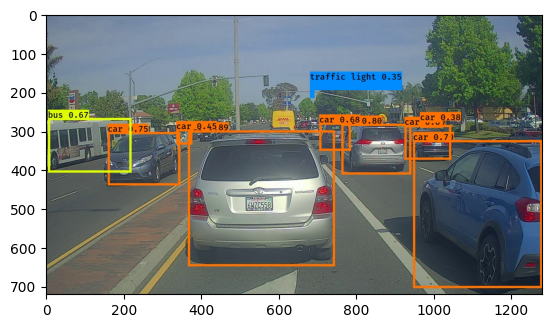

In [11]:
out_scores, out_boxes, out_classes = predict("test.jpg")

## 5 - References

The ideas presented in this notebook came primarily from the two YOLO papers. The implementation here also took significant inspiration and used many components from Allan Zelener's GitHub repository. The pre-trained weights used in this exercise came from the official YOLO website. 
- Joseph Redmon, Santosh Divvala, Ross Girshick, Ali Farhadi - [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640) (2015)
- Joseph Redmon, Ali Farhadi - [YOLO9000: Better, Faster, Stronger](https://arxiv.org/abs/1612.08242) (2016)
- Allan Zelener - [YAD2K: Yet Another Darknet 2 Keras](https://github.com/allanzelener/YAD2K)
- The official YOLO website (https://pjreddie.com/darknet/yolo/) 

### Car detection dataset

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">The Drive.ai Sample Dataset</span> (provided by drive.ai) is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>. Thanks to Brody Huval, Chih Hu and Rahul Patel for  providing this data. 